In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [56]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 40
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 2

## Model Parameters
num_particles = 50
num_particles_smc = 50
NUM_HIDDEN = 32
NUM_LATENTS = K*K
DIM_ENC_TRANS = 2 * K
DIM_ENC_DISPS = 2 * D

NUM_EPOCHS = 200
LEARNING_RATE = 1e-3
RESTORE = False
PATH_ENC = "baseline_smc/hao/baseline_2shots-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

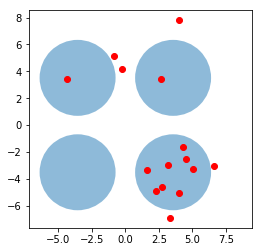

In [63]:
T = 15
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

[[  2.11739673 -23.25918345]
 [  3.44633895 -25.78237623]
 [  7.19433936 -29.6111663 ]
 [ 12.13431514 -26.42101492]
 [ 16.32324842 -25.71676264]
 [ 20.09542059 -22.19167561]
 [ 25.2761378  -21.68373302]
 [ 26.7215491  -19.27257779]
 [ 29.96554165 -16.29277221]
 [ 24.75322393 -12.68842833]
 [ 21.68109942  -9.59813356]
 [ 14.52151456  -7.14365978]
 [ 11.35698103  -0.55621036]
 [  7.93024114   2.95456581]
 [  3.29713394   5.39975012]
 [ -0.81923896   7.84213983]]


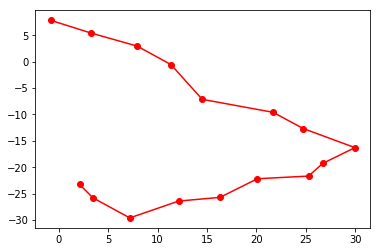

In [58]:
coor = STATE[:, :2]
print(coor)
plt.plot(coor[:,0], coor[:,1], 'r-o')

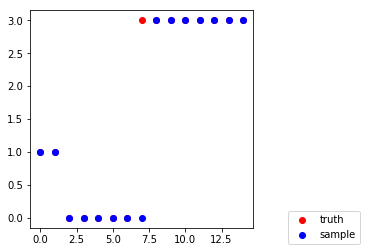

In [59]:
Zs, log_weights, log_normalizer = smc_hmm(Pi, A_true, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_ret = resampling_smc(Zs, log_weights)

plot_smc_sample(Zs_true, Z_ret)

In [26]:
torch.cat((Z_ret, Y), -1)

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000, -2.8487, -5.1458],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  2.6294, -5.8860],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  4.1885, -6.6590],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  8.0148, -6.4517],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  6.5144, -8.5190],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  4.6757, -5.7260],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  2.1978, -7.8296],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  6.0545,  3.9807],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  3.8564,  6.2683],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  4.7952,  6.1802],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  5.2622,  5.4497],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  2.2536,  6.3450],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  6.0584,  5.4471],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  2.1676,  5.9072],
        [ 0.0000,  0.0000,  0.0000,  1.0000, -6.6935,  4.7880]])

In [55]:
STATE

array([[-25.98023362,  16.47627052,  -4.86922898,  -6.34748841],
       [-28.82898209,  11.33049697,   4.86922898,  -6.34748841],
       [-26.19958407,   5.44448529,   4.86922898,  -6.34748841],
       [-22.01106531,  -1.2144963 ,   4.86922898,  -6.34748841],
       [-13.99623519,  -7.66619002,   4.86922898,  -6.34748841],
       [ -7.48183902, -16.18519192,   4.86922898,  -6.34748841],
       [ -2.80613109, -21.91117485,   4.86922898,  -6.34748841],
       [ -0.60833737, -29.74074878,   4.86922898,   6.34748841],
       [  5.44614008, -25.76005455,   4.86922898,   6.34748841],
       [  9.30254878, -19.49179588,   4.86922898,   6.34748841],
       [ 14.09779074, -13.31154599,   4.86922898,   6.34748841],
       [ 19.35999202,  -7.86181754,   4.86922898,   6.34748841],
       [ 21.61362895,  -1.51685562,   4.86922898,   6.34748841],
       [ 27.67202745,   3.93023965,   4.86922898,   6.34748841],
       [ 29.83961374,   9.83748687,   4.86922898,   6.34748841],
       [ 23.14610757,  14

In [54]:
box_bound = np.array([-1, 1, -1, 1]) * Boundary
def step1(state, box_bound, mu_ks):
    xy_new = np.copy(state[ :2]) + mvn.rvs(mean=np.copy(state[2: ]), cov=mu_ks)
    while(True):
        if xy_new[0] < box_bound[0]:
            print('if1')
            print(xy_new)
            x_over = abs(box_bound[0] - xy_new[0])
            xy_new[0] = box_bound[0] + x_over
            state[2] *= -1
        elif xy_new[0] > box_bound[1]:
            print('if2')
            x_over = abs(box_bound[1] - xy_new[0])
            xy_new[0] = box_bound[1] - x_over
            state[2] *= -1
        elif xy_new[1] < box_bound[2]:
            print('if3')
            y_over = abs(box_bound[2] - xy_new[1])
            xy_new[1] = box_bound[2] + y_over
            state[3] *= -1
        elif xy_new[1] > box_bound[3]:
            y_over = abs(box_bound[3] - xy_new[1])
            xy_new[1] = box_bound[3] - y_over
            state[3] *= -1
        else:
            state[:2] = xy_new
            break
    return state

step1(np.copy(STATE[0]), box_bound, noise_cov)

if1
[-30.45299317  10.42410231]


array([-29.54700683,  10.42410231,   4.86922898,  -6.34748841])

In [50]:
box_bound

array([-30,  30, -30,  30])

In [ ]:
class Encoder_Trans(nn.Module):
    def __init__(self, num_obs=DIM_ENC_TRANS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [ ]:
class Encoder_Disp(nn.Module):
    def __init__(self, num_obs=DIM_ENC_DISPS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [ ]:
def initialize():
    enc_trans = Encoder_Trans()
    enc_disp = Encoder_Disp()
    optimizer =  torch.optim.Adam(list(enc_trans.parameters()) + list(enc_disp.parameters()),lr=LEARNING_RATE)    
    return enc_trans, enc_disp, optimizer

enc_trans, enc_disp, optimizer = initialize()

In [ ]:
KLs = []
EUBOs = []
ESSs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    mu_ks, cov_ks, Pi, Y, A_true, Z_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
    eubo, kl, ess, latents_dirs_trans, elbo = twoshots_sampling(enc_trans, enc_disp, alpha_trans_0, Pi, mu_ks, cov_ks, Z_true, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f, KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

In [ ]:
plot_dirs(latents_dirs, alpha_trans_0, Z_true, T, K, vmax=15)

In [ ]:
plot_results(EUBOs, KLs, ESSs)

In [ ]:
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)